# 3. Inflação & deflação
(EN: **inflation / deflation**)

Um fato da vida é que preços de bens (comida, roupas, habitação etc) variam com o tempo. 

Quando essa variação é positiva (preços sobem), chamamos esse fenômeno de **inflação**; no caso de ela ser negativa (preços baixam), chamamos de **deflação**.

Quais preços? Onde? É necessário tomar algumas decisões: você mesmo pode ir ao seu mercado local, escolher meia dúzia de produtos e calcular uma média ponderada dos preços deles. Daqui a um mês, você repete o exercício e vê se esse preço ponderado sobe ou desce.

> Aqui, não vamos ainda entrar no mérito de *por que* preços sobem ou descem - você deve ter um entendimento baseado no vídeo do Ray Dalio, cujo link repetimos [aqui](https://www.youtube.com/watch?v=PHe0bXAIuk0) por bondade. O ponto é que eles variam - e isso afeta o poder de compra do consumidor.

### O IPCA

O **IPCA** (Índice de Preços ao Consumidor Amplo) é o exemplo brasileiro de um CPI (**Consumer Price Index**): um índice que agrega informações relativas a preços de bens para o consumidor.

Ele é calculado mensalmente pelo IBGE, e é considerado como nosso termômetro oficial de inflação. O valor dele é normalizado em 100 em Dez/1993.

> Veja [aqui](https://www.btgpactualdigital.com/como-investir/artigos/financas/ipca-o-que-e?cmpid=c04:m05:google:11177116067::110394111315&utm_medium=spl&utm_source=google&utm_campaign=11177116067&utm_content=110394111315&creative=603002635856&adposition=&keyword=&matchtype=&targetid=dsa-1592469244208&device=c&feeditemid=&loc_interest_ms=&loc_physical_ms=1001773&placement=&s_kwcid=AL!9288!3!603002635856!!!g!!&gclid=Cj0KCQjwy5maBhDdARIsAMxrkw0emDxCz87_aiuiq4rvK4THDOiB09EJYV0Nxq6SSAU7b7hNcbmTvs4aAuAVEALw_wcB) mais detalhes sobre o cálculo do IPCA.

> O IPCA se quebra em várias sub-categorias (por bens e região): ver [aqui](https://www.ibge.gov.br/estatisticas/economicas/precos-e-custos/9256-indice-nacional-de-precos-ao-consumidor-amplo.html?edicao=32709&t=destaques) uma interface interativa.

Note que a inflação é medida pelas **variações do IPCA**: se ele cresce, é porque houve inflação; se ele diminui, houve deflação.

Por exemplo: no fim de janeiro/2017, o IPCA estava em 4793.85 pontos; no fim de fevereiro ele fechou em 4809.67. Isso significa que a inflação de fevereiro/2017, segundo o IPCA, é

$$i_\mathrm{2017/02} = \frac{\mathrm{IPCA_{2017/02} - IPCA_{2017/01}}}{\mathrm{IPCA_{2017/01}}} = \frac{4809.67 - 4793.85}{4794.85} = 0.33\%$$

> É **muito** comum ouvir frases como "O IPCA de Fev/2017 foi de 0.33%". Essa frase é um abuso de linguagem: o que ela quer dizer é que o IPCA viu uma variação percentual de 0.33% no mês de Fev/2017 em relação ao mês anterior.

E quando dizemos que o **IPCA acumulado** ao longo de um ano, por exemplo? Novamente este é um abuso de linguagem; o que ele quer dizer é a variação percentual do IPCA entre dezembro daquele ano e dezembro do ano anterior. Por exemplo, em 2016 observamos um acumulado de 6.28%. Esse valor provém do fato que

$$\mathrm{IPCA_{2016/12}} = 4775.70$$
$$\mathrm{IPCA_{2015/12}} = 4493.17$$

e a variação percentual entre eles é de 6.28%.

### O IPCA acumulado

O valor acumulado anual **não** é igual à soma das variações mês a mês do IPCA ao longo do ano! Seja a inflação observada entre dois instantes $t_0$ e $t_f$ definida como

$$\pi(t_0, t_f) := \frac{\mathrm{IPCA}_{t_f} - \mathrm{IPCA}_{t_0}}{\mathrm{IPCA}_{t_0}}$$


> A notação $\pi$ para inflação é padrão.

Se tivermos três meses distintos $t_a < t_b < t_c$, o fato é que

$$\pi(t_a,t_b) + \pi(t_b, t_c) \neq \pi(t_a, t_c)$$

Por outro lado, assim como no caso da Selic, produtos (e não somas) são nossos amigos. Aqui, *é verdade* que

$$(1+\pi(t_a, t_b))(1+\pi(t_b, t_c)) = 1 + \pi(t_a, t_c)$$

e, usando argumentos idênticos aos do caso da Selic, podemos ver que se as variações mês-a-mês são $\ll 1$, então

$$\pi(t_a, t_c) \approx \exp[\pi(t_a, t_b) + \pi(t_b, t_c)] - 1$$

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import pandas as pd
from datetime import datetime

pd.options.mode.chained_assignment = None 

In [15]:
class IpcaLoader(DataLoader):

    def load_data_from_range(self, t0=None, tf=None):
        """
        Downloads IPCA data (absolute value of index). 
        OBS: the resulting DataFrame will have indices in the last day of the month, ie. the entry for
        the IPCA value calculated by the end of Oct/2022 will be in index 2022-10-31
        
        Ref: 
        https://dados.gov.br/dataset/ia-indice-nacional-de-precos-ao-consumidor-amplo-ipca/
        resource/c2c5d52f-4b7d-4f07-a26c-5614b2b54c1e

        Example:
        
        from datetime import datetime
        data = IpcaLoader().load_data_from_range(t0=datetime(2010,12,1))
        df = data.get_pandas()
        

        """

        if tf is None:
            tf = pd.to_datetime('today')
        
        if t0 is None:
            t0 = tf - pd.DateOffset(years=1)

        t0_str, tf_str = t0.strftime('%Y%m'), tf.strftime('%Y%m')
        self._download_series(t0_str, tf_str)
        self._json_to_dataframe()
        
        return self
            
    def _download_series(self, t0_str, tf_str):
        """API instructions: https://apisidra.ibge.gov.br/home/ajuda"""
        
        url = 'https://apisidra.ibge.gov.br/values/t/1737/n1/all/v/all/' + \
        f'p/{t0_str}-{tf_str}/d/v63%202,v69%202,v2266%2013,v2263%202,v2264%202,' + \
        'v2265%202?formato=json'
        
        req = requests.get(url)
        req.raise_for_status()
        
        self.json = req.json()
        return
    
    def _json_to_dataframe(self):
        
        from pandas.tseries.offsets import MonthEnd
        
        ipca_raw = pd.DataFrame(self.json)
        df = ipca_raw[ipca_raw['D2N'].isin(['IPCA - Número-índice (base: dezembro de 1993 = 100)'])]
        df['date'] = pd.to_datetime(df['D3C'], format='%Y%m') + MonthEnd(0)
        df = df.set_index('date')
        df['ipca'] = df['V'].astype(float)
        
        self.df = df[['ipca']]
        return

In [16]:
%%time
data2 = IpcaLoader().load_data_from_range(t0=datetime(2010, 1,1))
ipca = data2.get_pandas()

CPU times: user 29.2 ms, sys: 7.31 ms, total: 36.5 ms
Wall time: 6.83 s


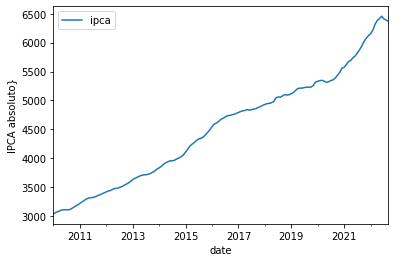

In [17]:
ipca.plot()
plt.ylabel("IPCA absoluto}")
plt.show()

**Um exemplo de como a soma das variações mensais é diferente da inflação acumulada**

In [18]:
ipca_2017 = ipca[ipca.index.to_series().isin(pd.date_range(start='2016-12-01', end='2017-12-31'))]
ipca_2017_monthly = (ipca_2017/ipca_2017.shift(1) - 1).dropna()

In [19]:
print("Soma das inflações mês-a-mês em 2017:", round(100*ipca_2017_monthly.sum().iloc[0],3), "%")

Soma das inflações mês-a-mês em 2017: 2.91 %


In [20]:
ipca_2017_year = (ipca.loc['2017-12-31']/ipca.loc['2016-12-31']-1).iloc[0]
print("Inflação acumulada em 2017:", round(100*ipca_2017_year,3), "%")

Inflação acumulada em 2017: 2.947 %


Veja que a diferença é sutil, mas não nula.

## A relação da inflação e a taxa de juros

In [23]:
selic = pd.read_parquet('../_data/selic.pqt')

Vamos plotar a curva de IPCA acumulado de 12 meses vs. a Selic:
    
> Por quê? Sabemos que um dos papéis do banco central é o controle da inflação via redefinição da taxa de juros básica, a Selic. Assim, esperamos que cenários de inflação crescente sejam acompanhados de aumentos na taxa de juros (com um delay), e, de forma análoga, que desacelerações na inflação sejam seguidas de reduções na Selic.

In [24]:
ipca['delta_year'] = ipca['ipca']/ipca['ipca'].shift(12) - 1

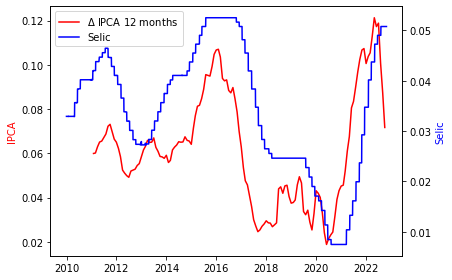

In [25]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ipca_line_year = ax1.plot(ipca.index, ipca.delta_year.values, label='$\Delta$ IPCA 12 months', color='red')
selic_line = ax2.plot(selic.index, selic['valor'], label='Selic', color='blue')
lns = ipca_line_year + selic_line 
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
plt.tight_layout()

ax1.set_ylabel('IPCA', color='red')
ax2.set_ylabel('Selic', color='blue')
plt.show()

De fato:
* Quando o IPCA começa a crescer, a Selic é impulsionada também;
* Quando o IPCA começa a baixar, a Selic é abaixada gradualmente

## A taxa de juros real: equação de Fisher

Um valor financeiro - 100 reais, por exemplo - sozinho não vale nada. 
O dinheiro vale aquilo que ele puder comprar; se um saco de arroz custa 10 reais, então 100 reais são 10 sacos, enquanto se o saco custa o dobro, só poderemos comprar 5.

Eu e você fazemos um acordo. Eu te empresto $M_0$ reais agora em $t=0$, a serem devolvidos daqui um tempo $T$. A taxa de juros que colocaremos nesse empréstimo é $i$, de forma que eu receberei de volta $M_0 (1 + i T)$.

Porém, durante este tempo, ocorreu inflação. Um bem que antes custava 1 real agora custa $1+\pi T$ em que $\pi$ é a inflação média neste período.

> Por exemplo, se $T= 1 \mbox{ ano}$ e o IPCA aumentou de 3000 para 3500 pontos, então 

$$\pi = \frac{3500}{3000}-1 = 16.67 \mbox{%/ano}$$

> As letras $i$ e $\pi$ para *juros nominal* e *inflação* são padrão nessa literatura.

Ou seja: se antes eu comprava $x$ bens com meus $M_0$ reais originais, agora, com esses mesmos $M_0$ reais, eu só posso comprar $x/(1+\pi T)$. Em termos de poder aquisitivo, eu fui de $M_0$ reais em $t = 0$ a 

$$M_T = M_0 \frac{1 + iT}{1 + \pi T}$$

em $t=T$: o juros $i$ contribui de forma a aumentar meu poder aquisitivo, enquanto a inflação contribui na direção oposta.

A **taxa real de juros** neste período sobre o empréstimo considerada é o valor $r$ tal que 

$$M_T = M_0 ( 1+r T)$$

Igualando as duas expressões, temos

$$\boxed{1 + rT = \frac{1+ i T}{1 + \pi T}}$$

Esta é a equação de Fisher. Ela costuma ser usada numa forma simplificada, notando que podemos aproximar o denominador via uma série geométrica:

$$\frac{1}{1 + \pi T} = 1 - \pi T + O(\pi^2 T^2)$$

de onde

$$1 + rT  = 1 + iT - \pi T + i \pi T^2 + O(\pi^2 T^2)$$

Ignorando termos quadráticos em $\pi$, $i$ e $i \pi$ obtemos

$$\boxed{r \approx i - \pi}$$

Apesar da simplicidade desta equação, sugerimos usar a original, sem aproximações, acima.

Note que a taxa de juros real pode mesmo ser negativa, se a inflação for alta demais.

### Cálculo da Selic real 

> Notícias sobre a taxa de juros real: [link](https://valorinveste.globo.com/mercados/moedas-e-juros/noticia/2022/09/21/brasil-continua-com-o-juro-real-mais-alto-do-mundo-apos-manutencao-da-selic.ghtml)



In [41]:
# TODO: tinha algo errado. A ser refeito